# Анализ поведения пользователей мобильного приложения

### Описание  проекта
Нужно разобраться, как ведут себя пользователи исследуемого мобильного приложения.
Изучим воронку продаж. Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

### Оглавление
- [Шаг 1. Изучение данных](#step1)
- [Шаг 2. Преобразуем данные](#step2)
- [Шаг 3. Проверим данные](#step3)
- [Шаг 4. Воронка событий](#step4)
- [Шаг 5. Результаты эксперимента](#step5)
- [Общий вывод](#step6)

### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 1. Изучение данных <a id=step1></a>

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
import datetime as dt

In [2]:
# настроим вывод формате 'svg' по дефолту
pio.renderers.default = "svg"

# создаем переменную для кастомизации настроек вывода графиков в формате 'svg'
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

In [3]:
logs = pd.read_csv('logs_exp.csv', sep='\t')
display(logs.head())
display(logs.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

In [4]:
logs.duplicated().sum()

413

In [5]:
logs = logs.drop_duplicates().reset_index(drop=True)
logs.shape

(243713, 4)

##### Вывод:
1. 244126 логов событий.
2. В данных нет пропусков.
3. Данные содержат 413 дубликатов, от которых мы избавились.
4. Изменим названия столцов, так они не отражают суть своего содержания.
5. Формат дат нечитабелен, неоходимо будет поправить это.

## Шаг 2. Преобразуем данные <a id=step2></a>

1. Изменим названия столбцов на более понятные.
2. Преобразуем столбец с датов в формат datetime.
3. Добавим столбец отдельно с датой и отдельно столбец со временем.

In [6]:
# Изменим названия столбцов
logs.columns = ['event_name', 'user_id', 'datetime', 'group']
logs.head()

,event_name,user_id,datetime,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [7]:
logs['datetime'] = pd.to_datetime(logs['datetime'], unit='s')
logs['date'] = logs['datetime'].astype('datetime64[D]')
logs['time'] = logs['datetime'].astype('datetime64[s]')
display(logs.head())
display(logs.info())

,event_name,user_id,datetime,group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,2019-07-25 11:48:42


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   datetime    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
 5   time        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 11.2+ MB


None

## Шаг 3. Проверим данные <a id=step3></a>

In [8]:
display(logs['user_id'].nunique())
display(logs.shape[0]/(logs['user_id'].nunique()))

7551

32.27559263673685

Text(0.5, 1.0, 'Количество событий на одного пользователя')

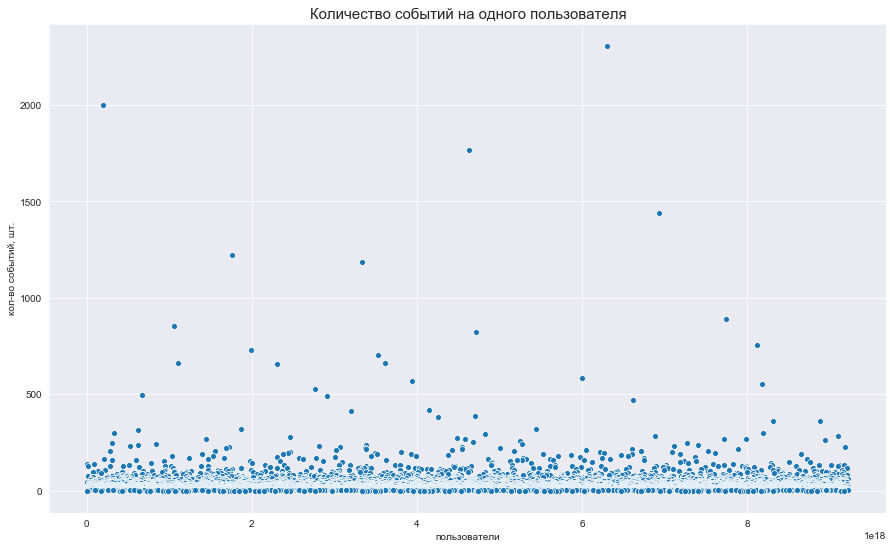

In [9]:
users_events = (logs.groupby('user_id').agg({'event_name':'count'}).
                reset_index().sort_values(by='event_name', ascending=False))

sns.set_style("darkgrid")
plt.subplots(figsize=(15, 9))
sns.scatterplot(data=users_events, x='user_id', y='event_name')
plt.xlabel('пользователи')
plt.ylabel('кол-во событий, шт.')
plt.title('Количество событий на одного пользователя', size=15)

Так как на графике мы видим сильные выбросы, то мы найдем медиану, чтобы понять, сколько примерно событий приходится на одного пользователя.

In [10]:
users_events['event_name'].median()

20.0

Мы имееем 243713 логов и 7551 уникального пользователя. Соответственно, на каждого пользователя в среднем приходится примерно 32 события.

In [11]:
display(max(logs['datetime']))
display(min(logs['datetime']))

Timestamp('2019-08-07 21:15:17')

Timestamp('2019-07-25 04:43:36')

- Самая ранняя дата: 2019-07-25 04:43:36
- Самая поздняя дата: 2019-08-07 21:15:17

Это значит, что у нас данные за 2 недели.

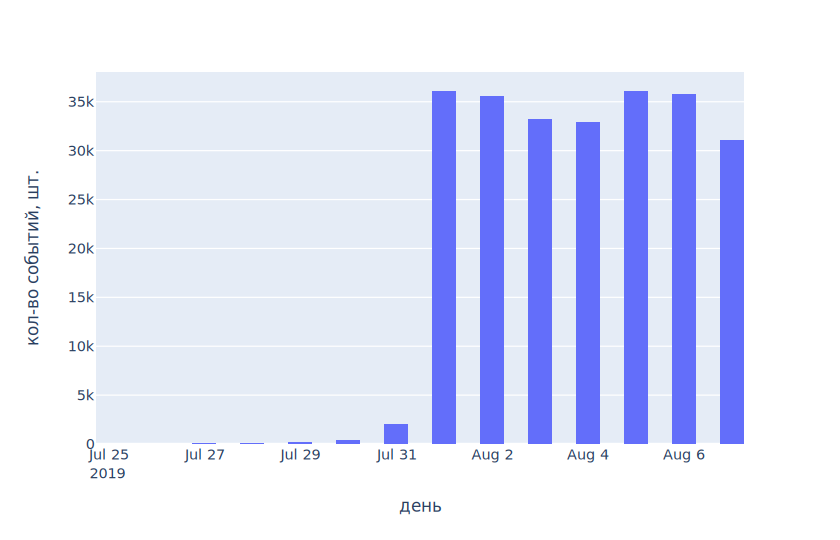

In [12]:
fig = px.histogram(logs, x='date', nbins=30)
fig.update_yaxes(title_text='кол-во событий, шт.')
fig.update_xaxes(title_text='день')
fig.show()

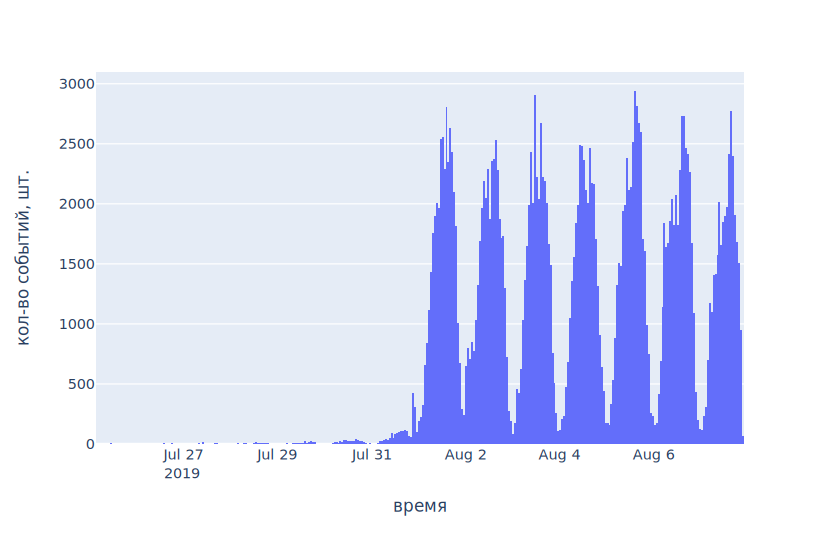

In [13]:
fig0 = px.histogram(logs, x='time')
fig0.update_yaxes(title_text='кол-во событий, шт.')
fig0.update_xaxes(title_text='время')
fig0.show()

По графику видно, что наши данные не одинаковы на протяжении всего периода времени. Более полные данные становятся только с 1 августа 2019 года, соответственно наша задача отбросить более старые данные.

In [14]:
logs_new = logs.query('date > "2019-07-31"')
display(logs_new.info())
display(logs_new.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2826 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   datetime    240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   date        240887 non-null  datetime64[ns]
 5   time        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 12.9+ MB


None

,event_name,user_id,datetime,group,date,time
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,2019-08-01 00:07:28
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,2019-08-01 00:08:00
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,2019-08-01 00:08:55
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,2019-08-01 00:08:58
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,2019-08-01 00:08:59


После избавления старых логов из 243713 осталось 240887, соответственно ушел примерно 1% всех данных.

In [15]:
logs_new.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

У нас в данных присутствуют пользователи из всех трех групп, однако в группах разное количество пользователей.

## Шаг 4. Воронка событий <a id=step4></a>

In [16]:
event_name_grouped = logs_new.groupby('event_name').agg({'user_id':'count'}).\
                    reset_index().sort_values(by='user_id', ascending=False)
event_name_grouped.columns = ['event_name', 'user_number']

# Посмотрим, сколько пользователей совершали каждое из событий
event_name_unique_users = logs_new.groupby('event_name').agg({'user_id':'nunique'})\
                            .reset_index().sort_values(by='user_id', ascending=False)
display(event_name_grouped)
display(event_name_unique_users)

,event_name,user_number
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [17]:
users_by_event = event_name_grouped.merge(event_name_unique_users, 
                                          left_on='event_name', right_on='event_name')

print('Доля пользователей, которые хоть раз совершали событие:', 
      round((logs_new['user_id'].nunique()/logs_new.shape[0])*100), '%')

Доля пользователей, которые хоть раз совершали событие: 3 %


In [18]:
event_name_unique_users

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [19]:
print('Всего уникальных пользователей:', logs_new['user_id'].nunique())

Всего уникальных пользователей: 7534


In [20]:
users_by_event['users_one_event'] = users_by_event['user_id']/users_by_event['user_number']*100
users_by_event

,event_name,user_number,user_id,users_one_event
0,MainScreenAppear,117328,7419,6.323299
1,OffersScreenAppear,46333,4593,9.913021
2,CartScreenAppear,42303,3734,8.826797
3,PaymentScreenSuccessful,33918,3539,10.433988
4,Tutorial,1005,840,83.582090


В таблице указаны следущие события:
- увидел гланую страницу;
- увидел страницу с предложенными товарами;
- увидел страницу с корзиной;
- увидел страницу оплаты;
- страница с инструкцией.

Именно в такой последовательности происходят события в приложении интернет-магазина, за исключением страниц с инструкцией, которая не обязательна к посещению для успешного оформления и оплаты заказа.

In [21]:
for i in range(1, 5):
    users_by_event.loc[i, 'conv'] = (users_by_event.loc[i, 'user_id']/users_by_event.loc[i-1, 'user_id'])*100
    
users_by_event

,event_name,user_number,user_id,users_one_event,conv
0,MainScreenAppear,117328,7419,6.323299,NaN
1,OffersScreenAppear,46333,4593,9.913021,61.908613
2,CartScreenAppear,42303,3734,8.826797,81.297627
3,PaymentScreenSuccessful,33918,3539,10.433988,94.777718
4,Tutorial,1005,840,83.582090,23.735519


In [22]:
funnel = users_by_event[['event_name', 'user_id']]\
    .assign(cr = lambda row: row['user_id'] / row['user_id'].shift())\
    .assign(share = lambda row: row['user_id'] / logs_new['user_id'].nunique())
funnel

,event_name,user_id,cr,share
0,MainScreenAppear,7419,NaN,0.984736
1,OffersScreenAppear,4593,0.619086,0.609636
2,CartScreenAppear,3734,0.812976,0.495620
3,PaymentScreenSuccessful,3539,0.947777,0.469737
4,Tutorial,840,0.237355,0.111495


In [23]:
list(funnel['user_id'])

[7419, 4593, 3734, 3539, 840]

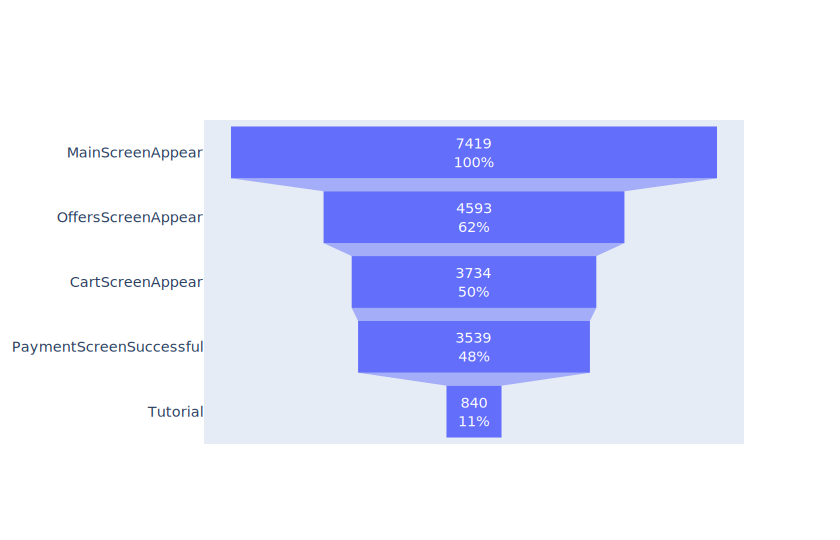

In [24]:
fig1 = go.Figure(go.Funnel(x=funnel['user_id'], 
                            y=funnel['event_name'], 
                            textinfo='value+percent initial'))
fig1.show()

Мы посчитали конверсии для каждого шага от числа предыдущего:
- 61,9% - переход на страницу с предложениями;
- 81,3% - переход на страницу корзины;
- 94,8% - переход на страницу оплаты.

Получается, что большая часть пользователей уходит сразу после главной страницы, то есть до страницы с предложениями они не доходят.

Если же говорить о доле пользователей, который доходят до оплаты от общего количества, то таких 17,6%.

## Шаг 5. Результаты эксперимента <a id=step5></a>

In [25]:
# Посмотрим, сколько пользователей в каждой экспериментальной группе

grouped_by_events = logs_new.pivot_table(index='event_name', columns='group', 
                     values='user_id', aggfunc='nunique').reset_index().sort_values(by=246, ascending=False)
display(grouped_by_events.info())
display(grouped_by_events)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 4
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_name  5 non-null      object
 1   246         5 non-null      int64 
 2   247         5 non-null      int64 
 3   248         5 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 200.0+ bytes


None

group,event_name,246,247,248
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
0,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181
4,Tutorial,278,283,279


In [26]:
grouped_by_events[493] = grouped_by_events[246] + grouped_by_events[247]
grouped_by_events

group,event_name,246,247,248,493
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


Проверим, будет ли статистически достоверное различие между группами 246 и 247, а также проверим это для каждого из событий. Узнаем, насколько корректно работает разбиение на группы.

In [27]:
event_name = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

def z_test(data):
    for i in range(0, 5):
        print(event_name[i])
        data_246 = data.query('group == "246"')
        data_247 = data.query('group == "247"')

        event_246 = (data_246.groupby('event_name').agg({'user_id':'nunique'}).
            sort_values(by='user_id', ascending=False))
        event_247 = (data_247.groupby('event_name').agg({'user_id':'nunique'}).
            sort_values(by='user_id', ascending=False))
        
        alpha = 0.01 #выбираем критический уровень статистической значимости

        p246 = event_246['user_id'][i]/data_246['user_id'].nunique() # пропорция успехов в первой группе
        p247 = event_247['user_id'][i]/data_247['user_id'].nunique() # пропорция успехов во второй группе

        # пропорция успехов в выборке, скомбинированной из двух:
        p_combined = (event_246['user_id'][i] + event_247['user_id'][i])/(
            data_246['user_id'].nunique() + data_247['user_id'].nunique())

        # разница пропорций в датасетах:
        difference = p246-p247

        z_value = difference / mth.sqrt(p_combined*(1 - p_combined)*(
            1/data_246['user_id'].nunique() + 1/data_247['user_id'].nunique()))
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу о равенстве долей выборки')
            print()
        else: 
            print('Не получилось отвергнуть нулевую гипотезу - нет оснований считать доли для групп 246 и 247 разными')
            print()

In [28]:
z_test(logs_new)

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу - нет оснований считать доли для групп 246 и 247 разными

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу - нет оснований считать доли для групп 246 и 247 разными

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу - нет оснований считать доли для групп 246 и 247 разными

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу - нет оснований считать доли для групп 246 и 247 разными

Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу - нет оснований считать доли для групп 246 и 247 разными



Для каждого этапа видим, что нет оснований отвергать нулевую гипотезу о равенстве долей, соответственно разбиение на группы работает корректно.

Теперь сравним результаты группы с измененным шрифтом с каждой из контрольных групп по отбельности, а затем с объединенной контрольной группой

In [29]:
def p_value (zvalue):
    
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу о равенстве долей выборки')
        print()
        print()
    else: 
        print(f"Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '{group[0]}' и '{group[1]}' различны, сделать нельзя")
        print()
        print()

In [30]:
data_grouped = logs_new.groupby('group').agg({'user_id':'nunique'}).reset_index()
data_grouped.loc[3] = data_grouped.loc[0]+data_grouped.loc[1]
data_grouped.loc[data_grouped['group'] == 248]['user_id']

2    2537
Name: user_id, dtype: int64

In [31]:
data_grouped

,group,user_id
0,246,2484
1,247,2513
2,248,2537
3,493,4997


In [32]:
grouped_by_events

group,event_name,246,247,248,493
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
0,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358
4,Tutorial,278,283,279,561


In [33]:
grouped_by_events.loc[grouped_by_events['event_name']=='CartScreenAppear', 247]

0    1238
Name: 247, dtype: int64

In [34]:
groups = ([246, 248], [247, 248], [493, 248])
event_name

for group in groups:
    for event in event_name:
        print(f"Тестируем группу '{group[0]}' против группы '{group[1]}' для события '{event}'")
        trials_1 = list(data_grouped.loc[data_grouped['group'] == group[0]]['user_id'])[0]
        trials_2 = list(data_grouped.loc[data_grouped['group'] == group[1]]['user_id'])[0]
        
        success_1 = list(grouped_by_events.loc[grouped_by_events['event_name'] == event, group[0]])[0]
        success_2 = list(grouped_by_events.loc[grouped_by_events['event_name'] == event, group[1]])[0]
        alpha = 0.05
        
        p1 = success_1/trials_1
        p2 = success_2/trials_2
        
        p_comb = (success_1 + success_2) / (trials_1 + trials_2)
        difference = p1-p2
        
        z_value = difference/mth.sqrt(p_comb * (1-p_comb) * (1/trials_1 + 1/trials_2))
        distr = st.norm(0, 1)
        
        p_value(z_value)

Тестируем группу '246' против группы '248' для события 'MainScreenAppear'
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'OffersScreenAppear'
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'CartScreenAppear'
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'PaymentScreenSuccessful'
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'Tutorial'
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую ги

Теперь скорректируем уровень значимости для проверки гипотез.

In [35]:
groups = ([246, 248], [247, 248], [493, 248])
event_name

for group in groups:
    for event in event_name:
        print(f"Тестируем группу '{group[0]}' против группы '{group[1]}' для события '{event}'")
        trials_1 = list(data_grouped.loc[data_grouped['group'] == group[0]]['user_id'])[0]
        trials_2 = list(data_grouped.loc[data_grouped['group'] == group[1]]['user_id'])[0]
        
        success_1 = list(grouped_by_events.loc[grouped_by_events['event_name'] == event, group[0]])[0]
        success_2 = list(grouped_by_events.loc[grouped_by_events['event_name'] == event, group[1]])[0]
        alpha = 0.0033 # применили метод Бонферрони для корректировки уровеня значимости, то есть поделили 0.05 на 15.
        
        p1 = success_1/trials_1
        p2 = success_2/trials_2
        
        p_comb = (success_1 + success_2) / (trials_1 + trials_2)
        difference = p1-p2
        
        z_value = difference/mth.sqrt(p_comb * (1-p_comb) * (1/trials_1 + 1/trials_2))
        distr = st.norm(0, 1)
        
        p_value(z_value)

Тестируем группу '246' против группы '248' для события 'MainScreenAppear'
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'OffersScreenAppear'
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'CartScreenAppear'
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'PaymentScreenSuccessful'
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу - вывод о том, то группы '246' и '248' различны, сделать нельзя


Тестируем группу '246' против группы '248' для события 'Tutorial'
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую ги

In [36]:
display(trials_1)
display(success_1)

4997

561

Всего у нас получилось 20 проверок для следующих пар групп: А1 и А2, А1 и В, А2 и В, АА и В. 

Изначально мы выбрали уровень значимости 0.05, но, когда перешли к множественной проверке гипотез, результаты при том же уровне значимости были бы некорректны, так возрастает вероятность ошибки первого рода, поэтому мы применили метод Бонферрони для корректировки уровня значимости.

## Общий вывод <a id=step6></a>
- Мы выяснили, что до покупки доходят всего 17,6% пользователей от общего числа.
- Самое большое количство людей уходит после этапа просмотра главной страницы, до страницы с товарами доходит 61,9% пользователей. 
- Мы знаем, что разбиение на группы происходит корректно, между группами А и А не наблюдается значимых различий.
- Такая разница в пропорциях недостаточна, чтобы говорить о значимых различиях между группами, соответственно шрифт не имеет сильного влияние на поведение пользователей приложения.